# Выбор локации для скважины

# Описание проекта  

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:** 
- Для обучения модели подходит **только линейная регрессия** (остальные — недостаточно предсказуемые).
- При разведке региона **исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших** для разработки.
- Бюджет на разработку скважин в регионе — **10 млрд рублей**.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. **Доход с каждой единицы продукта составляет 450 тыс. руб**, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно **оставить лишь те регионы, в которых вероятность убытков меньше 2.5%**. Среди них выбирают регион **с наибольшей средней прибылью**.


*Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.*


# Описание данных


Данные геологоразведки трёх регионов находятся в файлах: 
- `/datasets/geo_data_0.csv` 
- `/datasets/geo_data_1.csv` 
- `/datasets/geo_data_2.csv` 
- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).


# План работы: 
    
**1. Загрузить и подготовить данные.**


**2. Обучить и проверить модель для каждого региона:**
- Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
- Обучить модель и сделать предсказания на валидационной выборке.
- Сохранить предсказания и правильные ответы на валидационной выборке.
- Напечатать на экране средний запас предсказанного сырья и RMSE модели.
- Анализ результатов.


**3. Подготовиться к расчёту прибыли:**
- Все ключевые значения для расчётов сохранить в отдельных переменных.
- Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе. 
- Выводы по этапу подготовки расчёта прибыли.

**4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:**
- Выберать скважины с максимальными значениями предсказаний. 
- Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитать прибыль для полученного объёма сырья.

**5. Посчитать риски и прибыль для каждого региона:**
- Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков (это отрицательной прибыли).
- Выводы: предложить регион для разработки скважин и обоснуйте выбор.


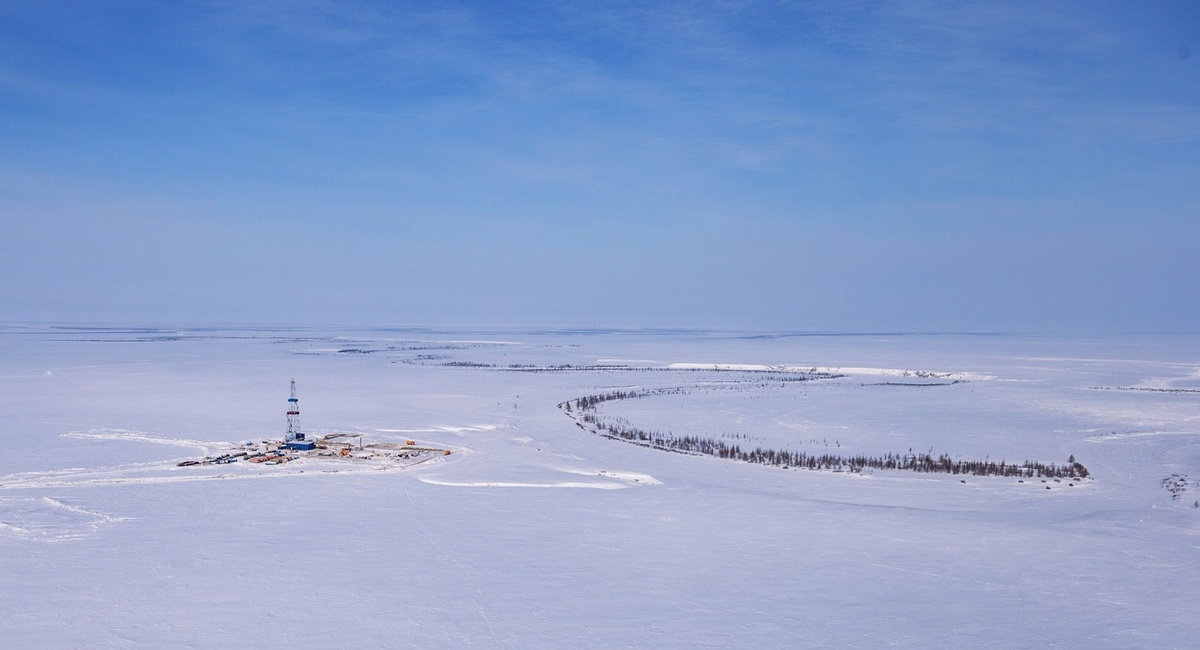

# 1. Загрузка и подготовка данных

## 1.1. Импортируем библиотеки для работы в проекте

In [1]:
# импортируем библиотеки для работы с проектом 
import pandas as pd 
import numpy as np 
import math

from numpy.random import RandomState
from scipy import stats as st

import matplotlib.pyplot as plt 
import seaborn as sb  

from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score 

state = np.random.RandomState(2023)

## 1.2. Ознакомление с данными 

### 1.2.1. Изучим данные из csv-файлов

#### Считаем данные из csv-файлов в датафреймы и сохраним в переменные data_0, data_1, data_2

In [2]:
# Изучим данные из csv-файла 
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')
except:
    data_0 = pd.read_csv('C:\\Users\\Natalia\\Desktop\\Yandex_Projects\\Project_M2_S3\\geo_data_0.csv')
    data_1 = pd.read_csv('C:\\Users\\Natalia\\Desktop\\Yandex_Projects\\Project_M2_S3\\geo_data_1.csv')
    data_2 = pd.read_csv('C:\\Users\\Natalia\\Desktop\\Yandex_Projects\\Project_M2_S3\\geo_data_2.csv')

    pd.set_option('display.max_columns', 50) # пока не знаем, насколько большой датафрейм, установим опцию 

**Далее в проекте будем называть:**
- **data_0** - нелевой датасет/ нулевое месторождение / нулевой регион 
- **data_1** - первый датасет/ первое месторождение / первый регион 
- **data_2** - второй датасет/ второе месторождение / второй регион 

#### Ознакомимся с информацией о датафреймах

Выведем первые 15 строчек датафреймов data_0, data_1, data_2 на экран.

In [3]:
# вывод первых 15 строк таблицы на экран для ознакомления с данными 
for i in [data_0, data_1, data_2]:
    print(i.head(15))
    print('')

       id        f0        f1        f2     product
0   txEyH  0.705745 -0.497823  1.221170  105.280062
1   2acmU  1.334711 -0.340164  4.365080   73.037750
2   409Wp  1.022732  0.151990  1.419926   85.265647
3   iJLyR -0.032172  0.139033  2.978566  168.620776
4   Xdl7t  1.988431  0.155413  4.751769  154.036647
5   wX4Hy  0.969570  0.489775 -0.735383   64.741541
6   tL6pL  0.645075  0.530656  1.780266   49.055285
7   BYPU6 -0.400648  0.808337 -5.624670   72.943292
8   j9Oui  0.643105 -0.551583  2.372141  113.356160
9   OLuZU  2.173381  0.563698  9.441852  127.910945
10  b8WQ6  0.371066 -0.036585  0.009208   70.326617
11  1YYm1  0.015920  1.062729 -0.722248   45.110381
12  zIYPq -0.276476  0.924865  0.095584   89.158678
13  iqTqq  0.212696 -0.111147  5.770095  164.298520
14  Ct5yY -0.018578  0.187516  2.944683  158.633720

       id         f0         f1        f2     product
0   kBEdx -15.001348  -8.276000 -0.005876    3.179103
1   62mP7  14.272088  -3.475083  0.999183   26.953261
2   v

**Ознакомимся с информацией о датафреймах методом info()**

In [4]:
for i in [data_0, data_1, data_2]:
    print(i.info())
    print('')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column

- Данные геологоразведки трёх регионов находятся в трех отдельных csv-файлах. Каждый файл содержит 5 стольбцов по 100 000 строк. Каждая строка представляет собой отдельную скважину на месторождении, имеющую уникальный идентификатор.
- Пропуски в исходных файлах не обнаружены.
- Данные в столбцах f0, f1, f2 (три признака точек) принимают положительные и отрицательные значения, с плавающей точкой. Не указано, что конкретоно означают данне признкаи точек. 

### 1.2.2. Визуализируем информацию для всех числовых столбцов таблицы

Построим общую гистограмму для всех числовых столбцов таблицы

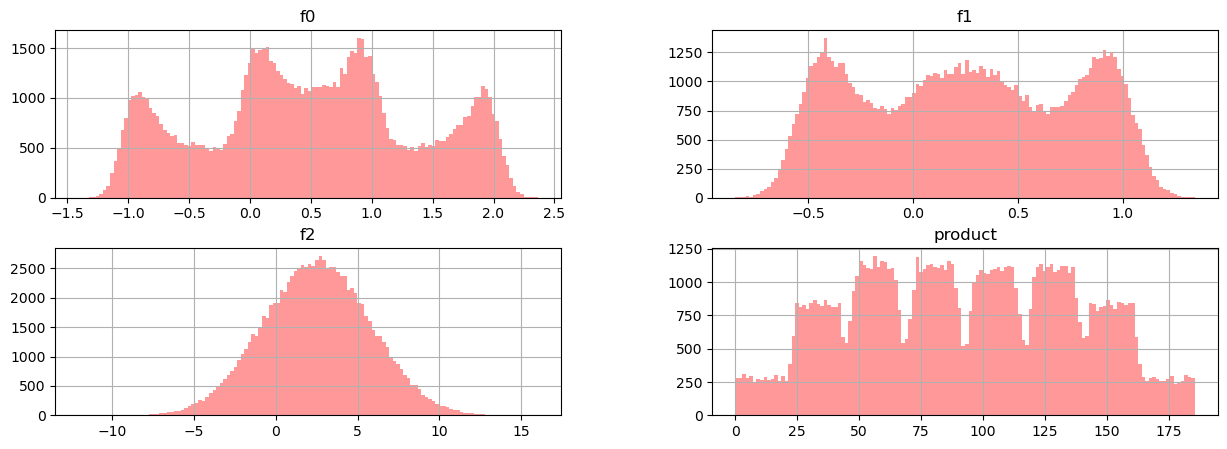

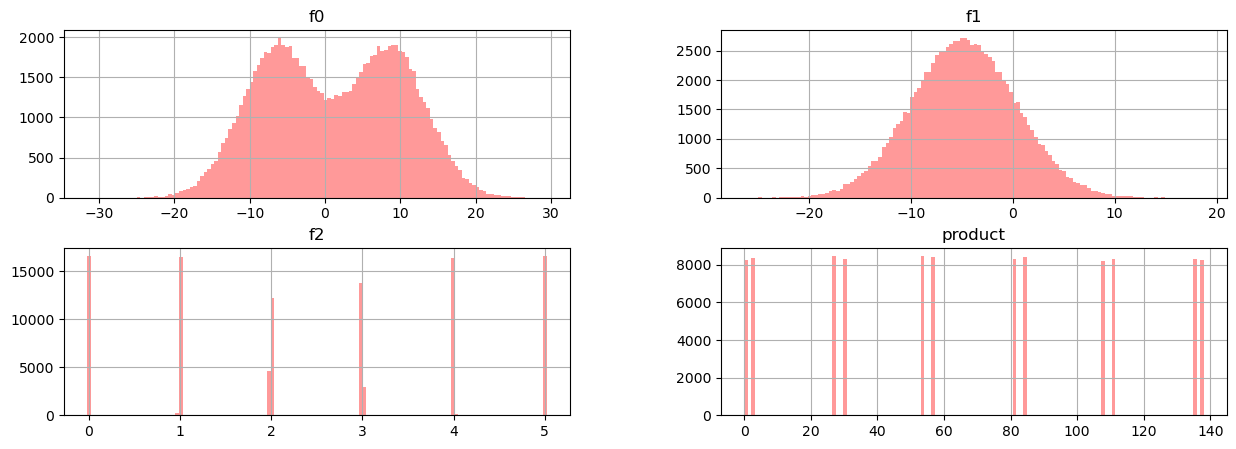

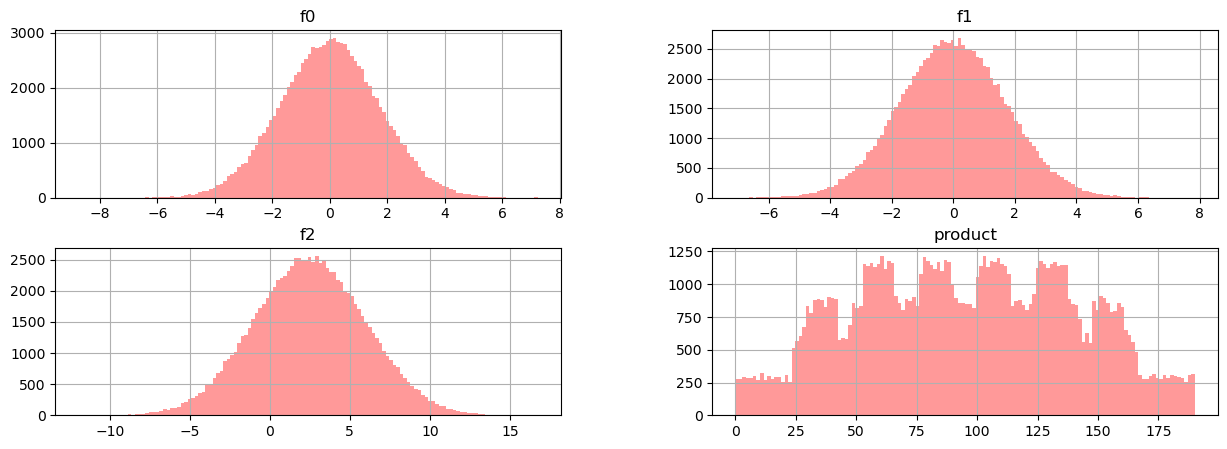

In [5]:
for i in [data_0, data_1, data_2]:
    i.hist(bins=130, figsize=(15, 5), color=('#FF9999'))

- Выбросы отсутствуют, все гистограммы симметричны относительно центральной оси (для каждого графика своя ось).  
- Гистограммы некоторых столбцов показывают нормальное распределение data_0 столбец `f2`,  data_1 столбец `f1`, data_2 столбцы `f0, f1, f2`. 

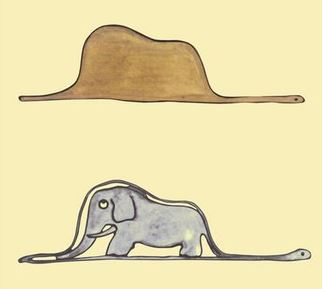

**Питон поглотил животных:)**

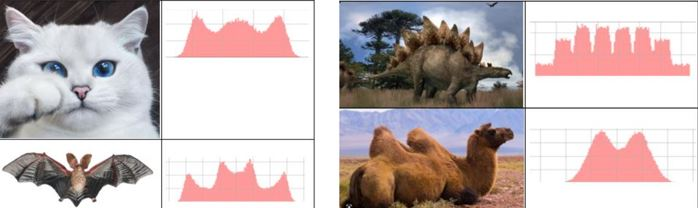

## 1.2. Предобработка данных

### 1.2.1. Проверим файлы на наличие дубликатов: 
- проверим полное совпадение строк 
- проверим совпадение уникальных идентификаторов скважины.

In [6]:
for i in [data_0, data_1, data_2]:
    print('Количество строк-дубликатов в файле:', i.duplicated().sum())
    print('Количество скважин-дубликатов в файле:', i.duplicated(['id']).sum())
    print(i[i.duplicated(['id'])])
    print('')

Количество строк-дубликатов в файле: 0
Количество скважин-дубликатов в файле: 10
          id        f0        f1         f2     product
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
66136  74z30  1.084962 -0.312358   6.990771  127.643327
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
90815  fiKDv  0.049883  0.841313   6.394613  137.346586
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
97785  bsk9y  0.378429  0.005837   0.160827  160.637302

Количество строк-дубликатов в файле: 0
Количество скважин-дубликатов в файле: 4
          id         f0        f1        f2     product
41906  LHZR0  -8.989672 -4.286607  2.009139   57.085625
82178  bfPNe  -6.202799 -4.820045  2.995107   84.038886
82873  wt4Uk  10.259972 -9.376355  4.994297  134.76630

Природа дубликатов неизвестна, возможно, по некоторм скважинам данные были внесены дважды (старые и новые). Если бы процент таких дуликатов был велик (скажем, от 5%), то я бы рекомендовала обратиться к бизнесу и запросить дополнительную информацию, чтобы обработать эти дубликаты правильно. 

В нашем случае количество дубликатов скважин ничтожное (10 скажин в первом файле, по 4 во втором и в третьем файлах), оно никак не повлияет на дальнейшее исследование и рабту с моделями.
Оставляем дубликаты без изменений. 

### 1.2.2. Удалим столбцы, которе не потребуются для анализа, обучения модели и предсказания:

Удалим столбцы `id` (уникальный идентификатор скважины) из каждого датасета, поскольку мы не делаем предсказания для каждой скважины отдельно, и эти данные не потребуются для обучения и работы модели. 

In [7]:
data_0 = data_0.drop(['id'], axis=1)
data_1 = data_1.drop(['id'], axis=1)
data_2 = data_2.drop(['id'], axis=1)

In [8]:
# проверим, что столбцы удалены 
for i in [data_0, data_1, data_2]:
    print(i.head(2))
    print('')

         f0        f1       f2     product
0  0.705745 -0.497823  1.22117  105.280062
1  1.334711 -0.340164  4.36508   73.037750

          f0        f1        f2    product
0 -15.001348 -8.276000 -0.005876   3.179103
1  14.272088 -3.475083  0.999183  26.953261

         f0        f1        f2    product
0 -1.146987  0.963328 -0.828965  27.758673
1  0.262778  0.269839 -2.530187  56.069697



#### Проверим полные дубликаты после удаления столбца с наименованиями скважин

Если в датасетах были разные скважины с одинаковыми параметрами, то после удаления их индентификаторов могли появиться дубликаты, что негативно скажется на модели (будем получать завышенную метрику на валидации). 

In [9]:
for i in [data_0, data_1, data_2]:
    print('Количество строк-дубликатов в файле:', i.duplicated().sum())

Количество строк-дубликатов в файле: 0
Количество строк-дубликатов в файле: 0
Количество строк-дубликатов в файле: 0


После удаления столбца id нове дубликаты не выявлены, следовательно, можем двигаться дальше. 

### 1.2.3.  Изучим корреляцию основных показателей каждого датасета

Далее в работе будет использоваться линейная модель, поэтому нам необходимо не столкнуться с мультиколлинеарностью (сильной корреляцией между признаками).

In [10]:
#выведем коэффициент корреляции на экран для среза 
for i in [data_0, data_1, data_2]:
    print(i.corr())
    print('')

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000

               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000

               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000



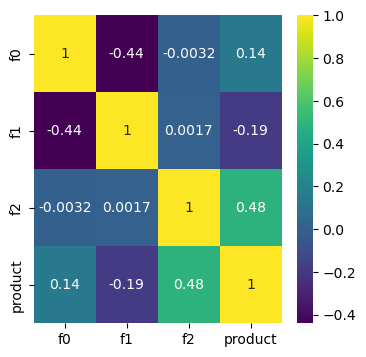

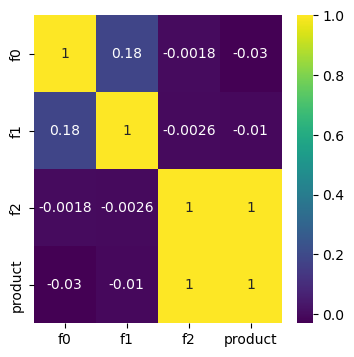

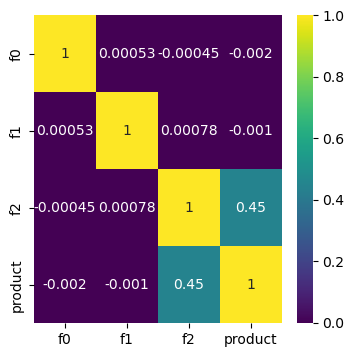

In [11]:
for i in [data_0, data_1, data_2]:
    plt.figure(figsize=(4,4))
    sb.heatmap(i.corr(), cmap='viridis', annot=True)
None

**Для комментариев корреляции воспользуемся  [Таблицей анализа силы связи между переменными](https://statpsy.ru/correlation/velicina/).**

**Нулевой датасет data_0:** 
- Слабая положительная корреляция (0.48) между признаком f2 и объёмом запасов в скважине product.
- слабая отрицательная корреляция (-0.44) между признаками f1 и f0. 
- Между остальными показателями корреляция очень слабая и не стоит внимания. 

**Первый датасет data_1:** 
- Очень высокая  положительная корреляция (0.9993) между признаком f2 и объёмом запасов в скважине product.
- Между остальными показателями корреляция очень слабая и не стоит внимания. 

**Второй датасет data_2:** 
- Слабая положительная корреляция (0.45) между признаком f2 и объёмом запасов в скважине product.
- Между остальными показателями корреляция очень слабая и не стоит внимания. 

### **ВЫВОД:** 
- Данные геологоразведки трёх регионов находятся в трех отдельных csv-файлах, содержащих **5 стольбцов по 100 000 строк** (скважин на месторождении, имеющих уникалный идентификатор). 
- **Пропуски не обнаружены.**
- **Выбросы отсутствуют.** 
- Гистограммы некоторых столбцов показывают **нормальное распределение** data_0 столбец f2, data_1 столбец f1, data_2 столбцы f0, f1, f2.
- Все **гистограммы симметричны относительно центральной оси** (для каждого графика своя ось).

- Обнаружено, изучено и оставлено без изменений незначительное количество **скважин-дубликатов** (10 в первом файле, по 4 во втором и в третьем файлах). 
Поскольку природа дубликатов неизвестна, а количество мизерное, то оставляем их без изменений, поскольку это никак не повлияет на дальнейшую работу. *В случае, если бы количество таких дубликатов было большим (от 5%), я бы рекомендовала обратиться к бизнесу и выяснить, не записаны ли данные по некторым скважинам дважды (старые и обновленне).* 

- **Удален столбец id (уникальный идентификатор скважины)** из каждого датасета, поскольку мы не делаем предсказания для каждой скважины отдельно, и эти данные не потребуются для обучения и работы модели.
- **Наиболее видимая корреляция** во всех датасетах обнаружена **между признаком f2 и объёмом запасов в скважине product.** В нулевом датасете слабая положительная корреляция (0.48), в первом датасете. Очень высокая  положительная корреляция (0.9993), во втором датасете слабая положительная корреляция (0.45). Также в нулевом датасете пристутствует слабая отрицательная корреляция (-0.44) между признаками f1 и f0. ежду остальными показателями корреляция очень слабая и не стоит внимания.

# 2. Обучение и проверка модели

**Для обучения и проверки качества модели создадим функцию, которая будет возвращать значения RMSE и R2 для оценки качества моделей.** 

**Внутри функции пропишем следующие действия:** 

1. Создадим из две переменные для каждого датасета  с признаками и целевым признаком:
- `features` — признаки. Содержит все столбцы, кроме `product`.
- `target` — целевой признак. Сюда запишем данные столбца `product`.
2. Разобьем данные на обучающую (`features_train`, `target_train`) и валидационную (`features_valid`, `target_valid`) выборки в соотношении 75:25.
3. Создадим и обучим модель линейной регрессии (`LinearRegression()` из библиотеки `sklearn`).  
4. Сделаем предсказания на валидационной выборке, запишем в переменную `predictions_model`.
5. Выведем на экран средний запас предсказанного `product_predicted` сырья и RMSE (квадратный корень из средней квадратичной ошибки) модели (также укажем R2*).
- *Для оценки качества модели линейной регрессии в классическом регрессионном анализе используется показатель, который называется коэффициентом детерминации R2 (коэффициент детерминации). Увеличение метрики означает прирост качества модели.



In [12]:
# Обучение и проверка модели - функция 
def ml_pipeline(data):
    
    '''Создадим из две переменные для каждого датасета с признаками и целевым признаком:'''
    features = data.drop(['product'], axis=1)
    target = data['product']
    
    '''Разобьем данные на обучающую и валидационную выборки в соотношении 75:25 для каждого датасета'''
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.25, 
                                                                              random_state=state)
    '''обучим модель''' 
    model = LinearRegression().fit(features_train, target_train) 
    
    '''получим предсказания модели с помощью валидационной выборки
    скорректируем индексы и переведем предсказания в серию, поскольку иначе в расчете выручки все время выскакивает ошибка'''
    predictions_model = pd.Series(model.predict(features_valid), index=features_valid.index) 
    
    '''рассчитаем RMSE'''
    rmse = (mean_squared_error(target_valid, predictions_model))**0.5 
    
    '''рассчитаем коэффициент детерминации'''
    r2 = r2_score(target_valid, predictions_model)
    
    '''рассчитаем среднее количество предсказанных запасов''' 
    product_predicted_mean = predictions_model.mean() 
   
    return product_predicted_mean, rmse, r2, predictions_model, target_valid

**Выведем средний запас предсказанного сырья, RMSE, R2 для каждой модели по порядку**

In [13]:
# Выведем Средний запас предсказанного сырья, RMSE, R2 для каждой модели по порядку 
for i in [data_0, data_1, data_2]:  
    product_predicted_mean, rmse, r2, predictions_model, target_valid = ml_pipeline(i)
    product_true_mean = i['product'].mean()
    print("Истинный средний запас сырья =  {:.3f}".format(product_true_mean), 'кБ')
    print("Средний запас предсказанного сырья = {:.3f}".format(product_predicted_mean), 'кБ')
    print("Соотношение истинного и предсказанного средних запасов:{:.2f}".format(
        (product_true_mean/product_predicted_mean)*100), '%')
    print('')
    print("RMSE = {:.3f}".format(rmse))
    print("R2 = {:.5f}".format(r2))
    print("___________________________________________________________________________________")

Истинный средний запас сырья =  92.500 кБ
Средний запас предсказанного сырья = 92.651 кБ
Соотношение истинного и предсказанного средних запасов:99.84 %

RMSE = 37.469
R2 = 0.27350
___________________________________________________________________________________
Истинный средний запас сырья =  68.825 кБ
Средний запас предсказанного сырья = 68.724 кБ
Соотношение истинного и предсказанного средних запасов:100.15 %

RMSE = 0.890
R2 = 0.99962
___________________________________________________________________________________
Истинный средний запас сырья =  95.000 кБ
Средний запас предсказанного сырья = 94.903 кБ
Соотношение истинного и предсказанного средних запасов:100.10 %

RMSE = 40.009
R2 = 0.19653
___________________________________________________________________________________


**Сохраним предсказания и правильные ответы на валидационной выборке**

In [14]:
product_predicted_mean_0, rmse_0, r2_0, predictions_model_0, target_valid_0 = ml_pipeline(data_0)
product_predicted_mean_1, rmse_1, r2_1, predictions_model_1, target_valid_1 = ml_pipeline(data_1)
product_predicted_mean_2, rmse_2, r2_2, predictions_model_2, target_valid_2 = ml_pipeline(data_2)

### **ВЫВОД:**
- **Регион, где добыча принесёт наибольшую прибыль - представлен во втором атасете data_2 (средний истинный и предсказанный запасы сырья около 95кБ).**  
- **Лучшая модель получена по первому датасету data_1: Средний запас предсказанного сырья 68.453, RMSE = 0.890, R2 =  0.999**
- **Среднее значение предсказанного запаса сырья** совпадает почти на 100% со средним значением истинного запаса срья, но мы не можем на этом основании судить о точности модели. Модель может ошибаться в большую или в меньшую сторону, тогда ошибки могут компенсировать друг друга. Чтобы определить точность модели, используем RMSE и R2.  
- **Значение RMSE** говорит нам, что среднее отклонение между прогнозируемыми запасами, сделанными моделью, и фактическими запасами составляет 37.579кБ,   0.893кБ и 39.962кБ для нулевого, первого и второго  месторождений соответственно.
- **Значение R2** говорит нам о том, что признаки точек f0, f1, f2 в модели способны объяснить 27.9%,  99,9% и 19.6% колебаний запасов.
- Мы видим, что значение RMSE для нулевой и второй модели больше, чем для первой модели. Мы также можем видеть, что значение R2 нулевой и второй модели меньше, чем для первой модели. Это говорит нам о том, что нулевая и вторая модели хуже, чем первая модель.


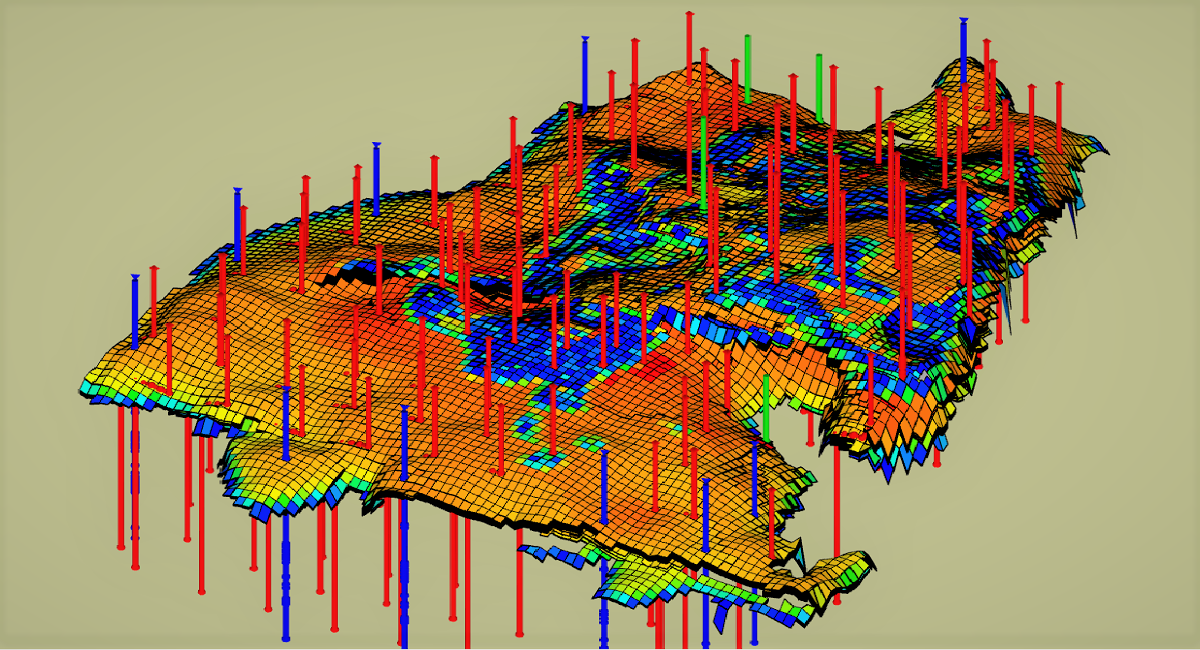

# 3. Подготовка к расчёту прибыли


Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. 
- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.


**Все ключевые значения для расчётов сохраним в отдельных переменных**


In [15]:
wells_total = 500 # При разведке региона исследуют 500 точек (скважин)
wells_best = 200 # 200 лучших точек (скважин) для разработки
budget_total = 10000000000 # бюджет на разработку в регионе (10 млрд руб.)
revenue_per_kb = 450000 # доход с каждой единицы продукта = 450 тыс. руб. (1 тыс. баррелей) 

**Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины** 

In [16]:
budget_per_well = budget_total/wells_best # бюджет на разработку 1 скважины из 200 
barrel_per_well = budget_per_well / revenue_per_kb # минимальнй достаточный объём сырья с одной скважины тыс. баррелей

**Выведем ключевые значения для расчётов прибыли и минимальную требуемую добычу с одной скважины на экран**

In [17]:
print("Ключевые значения для расчётов прибыли") 
print('')
print(wells_total, '- точек исследуется при разведке региона')
print(wells_best, '- лучших точек используются для разработки')
print(budget_total, 'руб - бюджет на разработку в регионе')
print(revenue_per_kb, 'руб - доход с каждой единицы продукта (с 1 тыс. баррелей)')
print('{:.0f}'.format(budget_per_well), 'руб - бюджет на разработку 1 скважины (из 200 лучших)')
print('')
print('{:.2f}'.format(barrel_per_well), 'тыс. баррелей - минимальнй достаточный объём сырья с одной скважины')

Ключевые значения для расчётов прибыли

500 - точек исследуется при разведке региона
200 - лучших точек используются для разработки
10000000000 руб - бюджет на разработку в регионе
450000 руб - доход с каждой единицы продукта (с 1 тыс. баррелей)
50000000 руб - бюджет на разработку 1 скважины (из 200 лучших)

111.11 тыс. баррелей - минимальнй достаточный объём сырья с одной скважины


**Сравним полученный минимальный объём сырья со средним запасом в каждом регионе**

In [18]:
print('Средний объем запасов в скважине:')
print('- в нулевом регионе: {:.2f}'.format(data_0['product'].mean()))
print('- в первом регионе: {:.2f}'.format(data_1['product'].mean()))
print('- во втором  регионе: {:.2f}'.format(data_2['product'].mean()))

Средний объем запасов в скважине:
- в нулевом регионе: 92.50
- в первом регионе: 68.83
- во втором  регионе: 95.00


Для того, чтобы разработка новой скважин окупилась, необходимо, чтобы запасы скважины были не меньше 111.11 килобаррелей, что существенно выше среднего обьема запасов в скважине по каждому региону (92.50кБ в нулевом, 68.83кБ в первом и 95.0кБ во втором регионе). 

**Обратимся к гистограммам обьема запасов в скважине:**

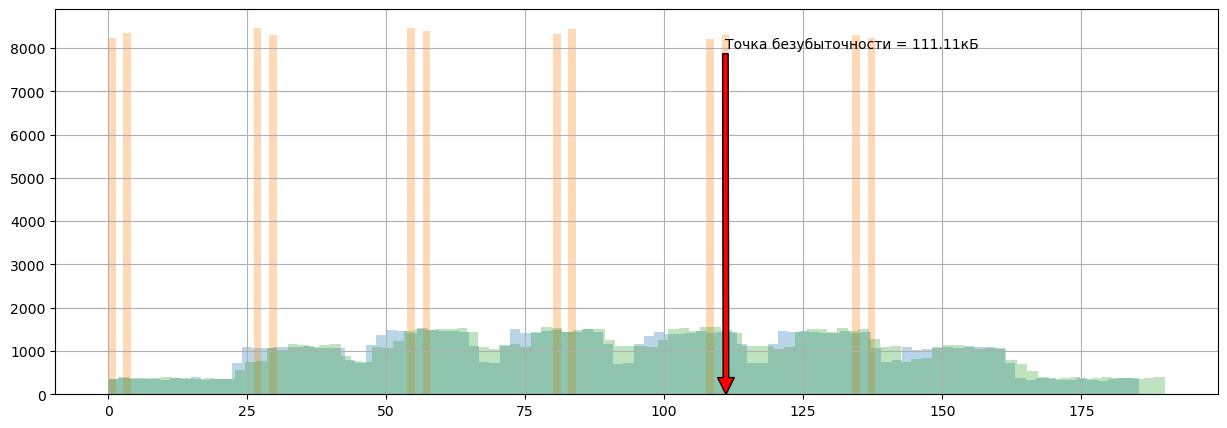

In [19]:
for i in [data_0, data_1, data_2]: 
    i['product'].hist(bins=100, figsize=(15, 5), alpha = 0.3)

# Добавим на график точку безубыточности 
plt.annotate('Точка безубыточности = 111.11кБ', xy=(barrel_per_well, 0), xycoords='data',
            xytext=(111, 8000), textcoords='data', 
            arrowprops=dict(facecolor='r'))

None 

Из гистограмм видно, что каджое месторождение имеет скважины с различным обьемом запасов. Некоторые выше минимального требуемого значения (111.11кБ), некоторые ниже. Значит для разработки необходимо выбрать топ-200 скважин, которе принесут наибольшую прибыль, и разработка которых окупится. 

**Посчитаем процент скважин в каждом датасете, в которых процент запасов выше точки безубыточности** 

In [20]:
# Выделим безубточные скважин 
data_0_profitable = data_0.query('product >= 111.12')
data_1_profitable = data_1.query('product >= 111.12')
data_2_profitable = data_2.query('product >= 111.12')

In [21]:
# Посчитаем процент безубточнх скважин 
print("Безубыточные скважины, запасы которых выше 111.11кБ") 
print("- на нулевом месторождении:", len(data_0_profitable), "шт,", len(data_0_profitable)/len(data_0)*100, "%")
print("- на первом месторождении:", len(data_1_profitable), "шт,",len(data_1_profitable)/len(data_1)*100, "%")
print("- на втором месторождении:", len(data_2_profitable), "шт,",len(data_2_profitable)/len(data_2)*100, "%")

Безубыточные скважины, запасы которых выше 111.11кБ
- на нулевом месторождении: 36577 шт, 36.577 %
- на первом месторождении: 16537 шт, 16.537 %
- на втором месторождении: 38171 шт, 38.171 %


Самое большое количество безубточных скважин на втором месторождении (38 171 шт, 38.171 %), чуть меньше нулевом месторождении (36 577 шт, 36.577 %) и самое маленькое количество на втором месторождении (16 537 шт, 16.537 %). Но мы ориентируемся не на количество скважин, а на прибыль, которую можем получить с добычи ископаемых на месторождении. Другими словами, необходимо учитывать не только количество скважин с запасами выше точки безубыточности, но и качество (насколько больше запасы каждой из них). 

Значит для разработки необходимо выбрать топ-200 скважин, которе принесут наибольшую прибыль, и разработка которых окупится. 

### **ВЫВОД:** 
- **Минимальнй достаточный объём сырья с одной скважины 111.11 кБ.** 
-Для того, чтобы разработка новой скважин окупилась, необходимо, чтобы запасы скважины были не меньше 111.11 кБ, что существенно выше среднего обьема запасов в скважине по каждому региону (92.50кБ в нулевом, 68.83кБ в первом и 95.0кБ во втором регионе). 
- Каджое месторождение имеет скважины с различным обьемом запасов. Некоторые выше минимального требуемого значения (111.11кБ), некоторые ниже. 
- Самое большое количество безубточных скважин на втором месторождении (38 171 шт, 38.171 %), чуть меньше нулевом месторождении (36 577 шт, 36.577 %) и самое маленькое количество на втором месторождении (16 537 шт, 16.537 %). Но мы ориентируемся не на количество скважин, а на прибыль, которую можем получить с добычи ископаемых на месторождении.  Значит для разработки необходимо выбрать топ-200 скважин, которе принесут наибольшую прибыль, и разработка которых окупится. 

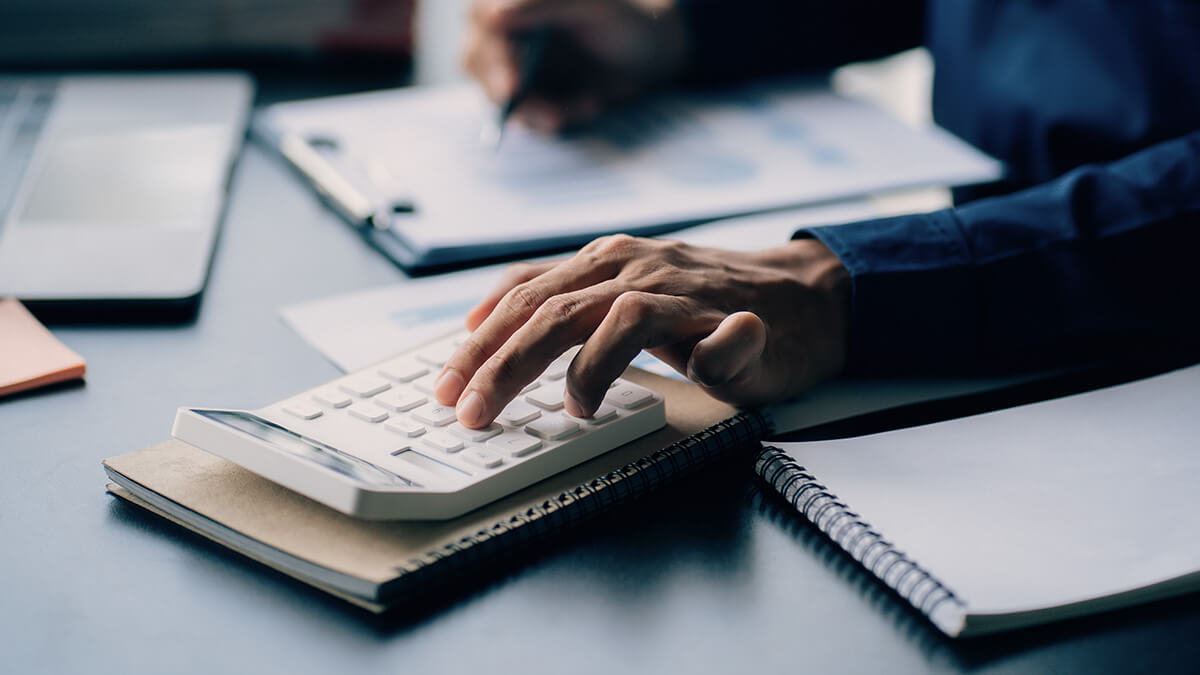

# 4. Расчёт прибыли и рисков 

## 4.1. Напишем функцию для расчета прибыли 

Напишем функцию revenue(), которая подсчитывает и возвращает прибыль.
Она получает на вход:
- список правильных ответов `target_valid`;
- список предсказаний обученной модели `predictions_model`;
- количество скважин для расчета `count`.



In [22]:
# Напишem функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
def revenue(target_valid, predictions_model, count):
    
    '''вделим в отдельный датафрейм список правильных ответов target_valid и список предсказаний 
    обученной модели predictions_model, чтобы закончить страдания с перепутавшимися индексами и задублированными значениями''' 
    
    df_rev_calc= pd.DataFrame({'target_valid': target_valid, 'predictions_model': predictions_model})
    
    '''сортируем скважины по убыванию значений предсказаний и вбираем выбираем скважины 
    с максимальными значениями предсказаний, суммируем целевое значение объёма сырья, соответствующее этим максимальным 
    предсказаниям, и считаем прибль для полученного сырья''' 
    
    selected = df_rev_calc.sort_values(by='predictions_model', ascending=False)['target_valid'][:count]

    rev = ((revenue_per_kb * selected.sum()) - budget_total)
        
    return rev

**Рассчитаем прибыль для суммарного объёма сырья от 200 скважины с максимальными значениями предсказаний**

In [23]:
print('Прибль с 200 лучших скважин') 
print('- на нулевом месторождении {:.2f}'.format(revenue(target_valid_0, predictions_model_0, wells_best)/1000000000), 'млрд.руб')
print('- на первом месторождении {:.2f}'.format(revenue(target_valid_1, predictions_model_1, wells_best)/1000000000), 'млрд.руб')
print('- на втором месторождении {:.2f}'.format(revenue(target_valid_2, predictions_model_2, wells_best)/1000000000), 'млрд.руб')


Прибль с 200 лучших скважин
- на нулевом месторождении 3.20 млрд.руб
- на первом месторождении 2.42 млрд.руб
- на втором месторождении 2.10 млрд.руб


### **ВЫВОД:**
Каждое месторождение из рассматриваемх является прибыльным при грамотной разработке. Если выбрать для бурения точки с максимальными значениями предсказаний, то уже 200 скважин окупят разработку и принесут существенную прибль. 
    

## 4.2. Посчитаем риски и прибыль для каждого региона 

**Напишем функцию, в которой сгенерируем 1000 выборок по 500 случайных скважин в каждой, чтобы найти распределение прибыли** 

In [24]:
def bootstrap(target_valid, predictions_model):
    
    values = []
    
    for i in range(1000):
        target_subsample = target_valid.sample(n=wells_total, replace=True, random_state=state) 
        preds_subsample = predictions_model[target_subsample.index]
        rev = revenue(target_subsample, preds_subsample, wells_best)
        values.append(rev)

    values = pd.Series(values)
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975) 
    revenue_mean = values.mean()
    risk = st.percentileofscore(values, 0) 
    
    return values, lower, upper, revenue_mean, risk

**Сохраним результаты работы функции по каждому датасету в соответствующие пременне**

In [25]:
values_0, lower_0, upper_0, revenue_mean_0, risk_0 = bootstrap(target_valid_0, predictions_model_0)
values_1, lower_1, upper_1, revenue_mean_1, risk_1 = bootstrap(target_valid_1, predictions_model_1)
values_2, lower_2, upper_2, revenue_mean_2, risk_2 = bootstrap(target_valid_2, predictions_model_2)

**Выведем на экран статистичекие характеристики для распределения каждого месторождения**

In [26]:
print('-------------------------------------------------------------------')
print("Нулевое месторождение:")
print('')
print("Средняя прибыль: {:.2f}".format(revenue_mean_0/1000000), 'млн.руб')
print("Доверительный интервал от {:.2f}".format(lower_0/1000000), "млн.руб до {:.2f}".format(upper_0/1000000), 'млн.руб')
print("Риск убытков: {:.2f}".format(risk_0), '%')
print('-------------------------------------------------------------------')
print("Первое месторождение:")
print('')
print("Средняя прибыль: {:.2f}".format(revenue_mean_1/1000000), 'млн.руб')
print("Доверительный интервал от {:.2f}".format(lower_1/1000000), "млн.руб до {:.2f}".format(upper_1/1000000), 'млн.руб')
print("Риск убытков: {:.2f}".format(risk_1), '%')
print('-------------------------------------------------------------------')
print("Второе месторождение:")
print('')
print("Средняя прибыль: {:.2f}".format(revenue_mean_2/1000000), 'млн.руб')
print("Доверительный интервал от {:.2f}".format(lower_2/1000000), "млн.руб до {:.2f}".format(upper_2/1000000), 'млн.руб')
print("Риск убытков: {:.2f}".format(risk_2), '%')
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
Нулевое месторождение:

Средняя прибыль: 351.08 млн.руб
Доверительный интервал от -120.33 млн.руб до 894.62 млн.руб
Риск убытков: 8.10 %
-------------------------------------------------------------------
Первое месторождение:

Средняя прибыль: 441.15 млн.руб
Доверительный интервал от 54.59 млн.руб до 841.59 млн.руб
Риск убытков: 1.20 %
-------------------------------------------------------------------
Второе месторождение:

Средняя прибыль: 330.16 млн.руб
Доверительный интервал от -200.70 млн.руб до 850.74 млн.руб
Риск убытков: 10.60 %
-------------------------------------------------------------------


### **Визуализируем распределение прибыли и доверительне интервалы** 

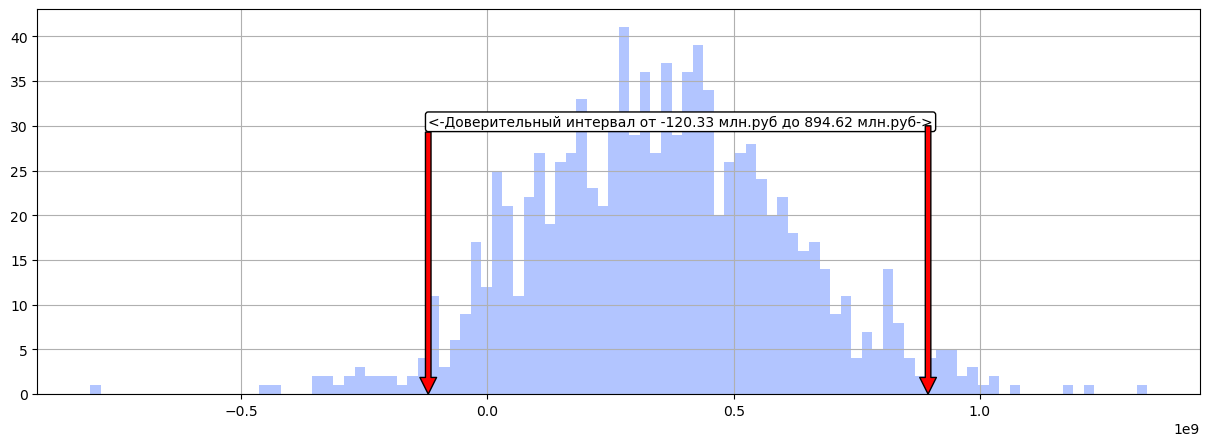

In [38]:
values_0.hist(bins=100, figsize=(15, 5), alpha = 0.5, color=('#678cff'))

# Добавим на график точки доверительного интервала 
bbox_properties=dict(boxstyle="round,pad=0.2", fc="w")
plt.annotate('<-Доверительный интервал от -120.33 млн.руб до 894.62 млн.руб->', xy=(lower_0, 0), xycoords='data',
            xytext=(lower_0, 30), textcoords='data', arrowprops=dict(facecolor='r'), bbox=bbox_properties)
plt.annotate('', xy=(upper_0, 0), xycoords='data',
            xytext=(upper_0, 30), textcoords='data', arrowprops=dict(facecolor='r'))
None 

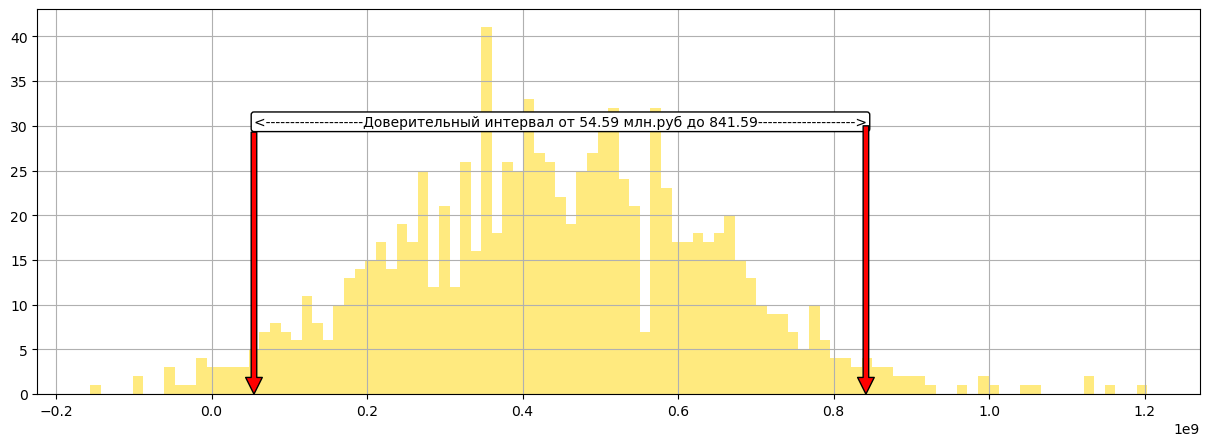

In [39]:
values_1.hist(bins=100, figsize=(15, 5), alpha = 0.5, color=('#FFD700'))

# Добавим на график точки доверительного интервала 
bbox_properties=dict(boxstyle="round,pad=0.2", fc="w")
plt.annotate('<--------------------Доверительный интервал от 54.59 млн.руб до 841.59-------------------->', 
             xy=(lower_1, 0), xycoords='data', xytext=(lower_1, 30), textcoords='data', 
             arrowprops=dict(facecolor='r'), bbox=bbox_properties)
plt.annotate('', xy=(upper_1, 0), xycoords='data',
            xytext=(upper_1, 30), textcoords='data', arrowprops=dict(facecolor='r'))
None 

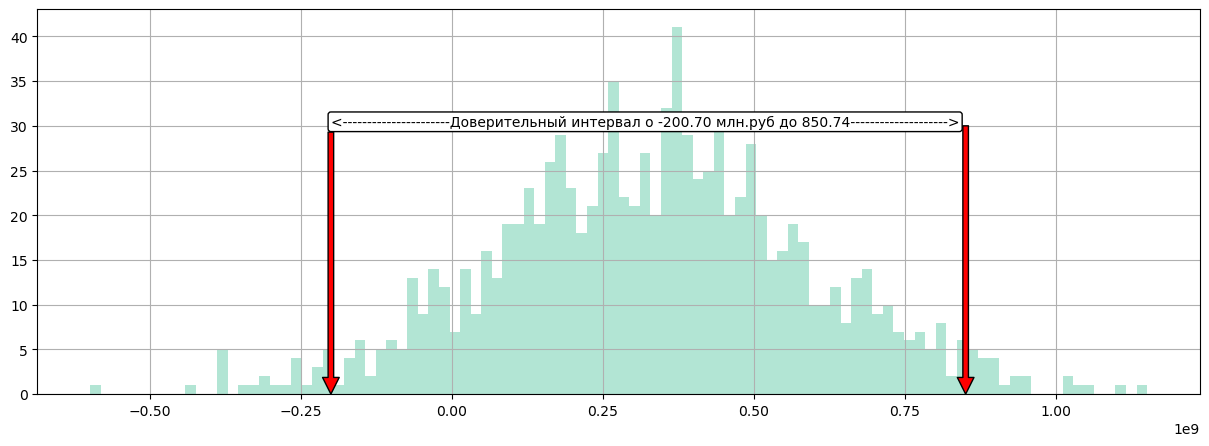

In [41]:
values_2.hist(bins=100, figsize=(15, 5), alpha = 0.5, color=('#66CDAA'))

# Добавим на график точки доверительного интервала 
bbox_properties=dict(boxstyle="round,pad=0.2", fc="w")
plt.annotate('<----------------------Доверительный интервал о -200.70 млн.руб до 850.74-------------------->', 
             xy=(lower_2, 0), xycoords='data', xytext=(lower_2, 30), textcoords='data', 
             arrowprops=dict(facecolor='r'), bbox=bbox_properties)
plt.annotate('', xy=(upper_2, 0), xycoords='data',
            xytext=(upper_2, 30), textcoords='data', arrowprops=dict(facecolor='r'))
None 

**После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. 
Среди них выбирают регион с наибольшей средней прибылью.**

- **Самая большая средняя прибыль** получается на **первом месторождении data_1 (441.15  млн.руб)**, с вероятностью 95% прибыль будет находиться в **интервале 54.59 - 841.59  млн.руб.**. 
- **Самый маленький риск убытков (1.2%)** также на **первом месторождении data_1**, что ниже установленных 2.5%. 
- Второе месторождение data_2  и нулевое месторождние data_0  имеют более низкую среднюю прибль (351.08 млн.руб  и 330.16 млн.руб соответственно), а также высокие риски убытков (8.1% и 10.6% соответственно, что выше установленным порогом в 2.5%), следовательно они не прододят.  


**ВЫВОД:** 
**Для разработки рекомендуется первое месторождение data_1**, поскольку здесь ожидается наибольшая прибыль и это единственное месторождение ниже пороговых 2.5% рисков. 
- **441.15 млн.руб** - средняя прибыль месторождения data_1, 
- **54.59 - 841.59 млн.руб** - интервал, в котором можно полуить прибыль с 95% вероятностью,
- **1.2%** - риск убытков, что значительно ниже пороговоро значения 2.5%


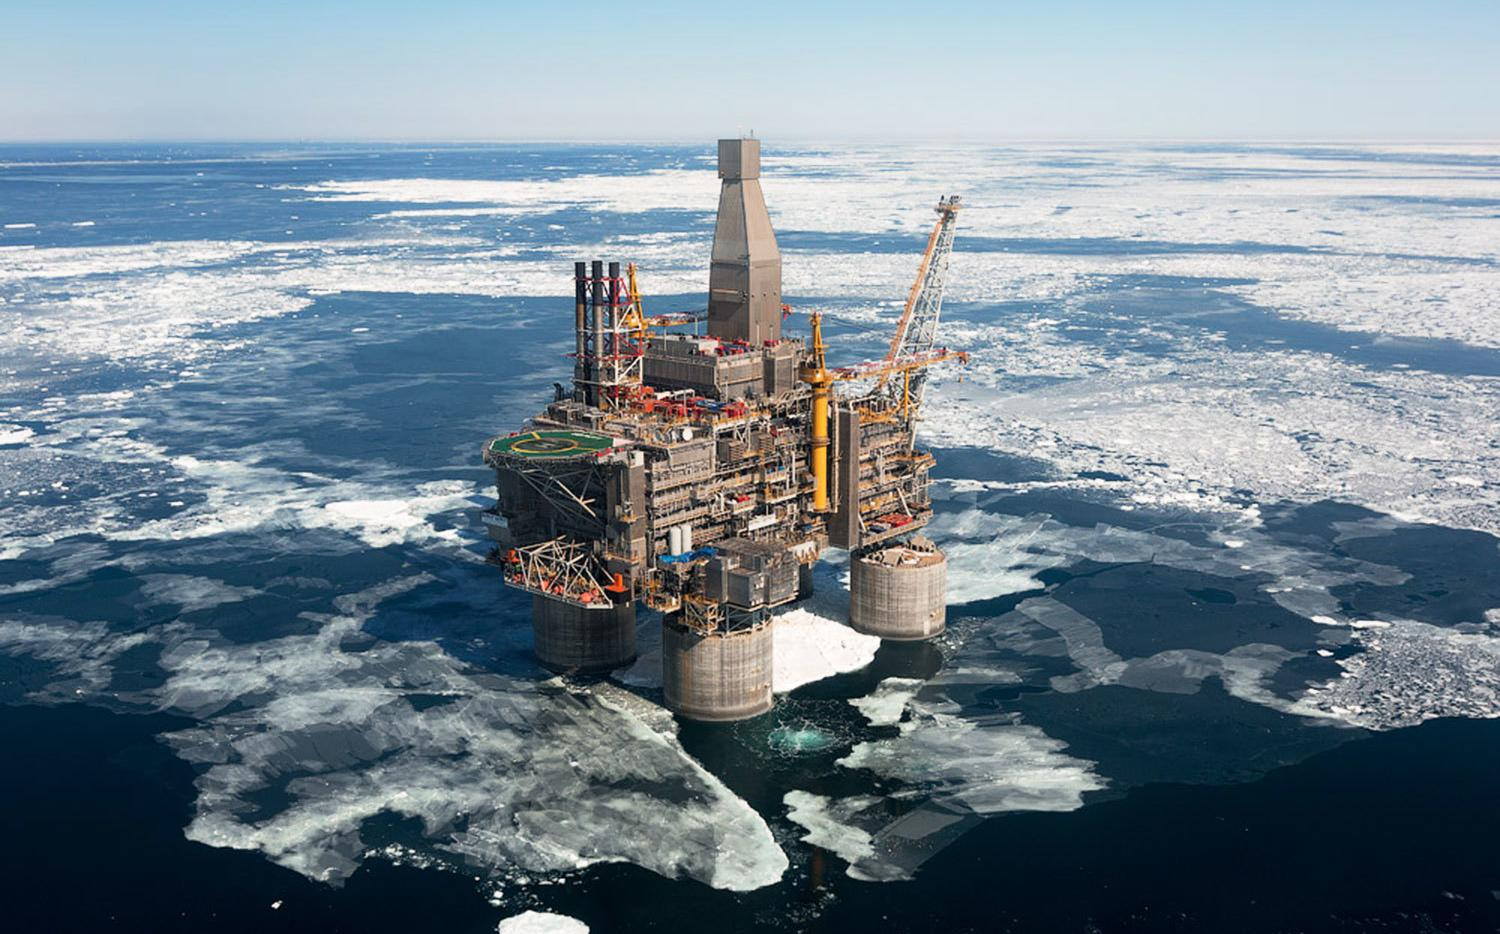

# Итоговый вывод



- В ходе проекта построены модели линейной регрессии для задачи регрессии, которые прогнозируют обьемы запасов в скважинах на трех месторождениях. Модели обучены и протестированы на синтетических данных: детали контрактов и характеристики месторождений не разглашаются.

- На основании значений метрик RMSE и R2 выбрана лучшая модель, которая с наибольшей точностью прогнозирует запасы нефти. Лучшая модель получена по первому датасету data_1: Средний запас предсказанного сырья 68кБ, RMSE = 0.89, R2 = 0.99.

- Применена техника Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдена средняя прибыль, 95%-й доверительный интервал и риск убытков. В результате: 

**Для разработки рекомендуется первое месторождение data_1**, поскольку здесь ожидается наибольшая прибыль и это единственное месторождение ниже пороговых 2.5% рисков. 
- **441.15 млн.руб** - средняя прибыль месторождения data_1, 
- **54.59 - 841.59 млн.руб** - интервал, в котором можно полуить прибыль с 95% вероятностью,
- **1.2%** - риск убытков, что значительно ниже пороговоро значения 2.5% 




